# Librerías

In [1]:
import math
import cmath
import scipy
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from datetime import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from scipy.stats import kurtosis
from apyori import apriori
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix
import seaborn as sns;
sns.set_theme()
sns.set(rc={'figure.figsize':(8,6)})
from itertools import combinations
import array_to_latex as a2l
import matplotlib.colors as colors

dirfigs="figs/"
dirtabs="tablas/"
#dirfigs="/home/ogduartev/Cursos/Ciencia\ de\ datos\ energéticos/textos/agrupamientoDeConsumos/figs/"
#dirtabs="/home/ogduartev/Cursos/Ciencia\ de\ datos\ energéticos/textos/agrupamientoDeConsumos/tablas/"

# Funciones

In [2]:
def leerUN(target_url):
    df = pd.read_csv(target_url,sep='\t');
    df['FECHA']=pd.to_datetime(df['FECHA'],format='%Y/%m/%d')
    df['HORA']=pd.to_datetime(df['HORA'],format='%H:%M:%S')
    hora=[''] * df["HORA"].size
    for ind in df.index:
        x=df["HORA"][ind]
        hora[ind]=x.strftime("%H")
    df["HORA"]=hora
    return df;

def fasores(Ia,Ib,Ic,giro):
    # obtención de los ángulos de un triángulo a partir de sus lados
    mm=(Ib*Ib + Ic*Ic - Ia*Ia)/(2*Ib*Ic);
    mm=min(1.0,max(-1.0,mm))
    a=math.acos(mm)
    mm=(Ic*Ic + Ia*Ia - Ib*Ib)/(2*Ic*Ia)
    mm=min(1.0,max(-1.0,mm))
    b=math.acos(mm)
    mm=(Ia*Ia + Ib*Ib - Ic*Ic)/(2*Ia*Ib)
    mm=min(1.0,max(-1.0,mm))
    c=math.acos(mm)
    # ángulos para un sistema trifásico:
    aa=giro;
    bb=giro+math.pi-c;
    cc=giro+math.pi+b;
    j=complex(0,1);
    IIa = Ia*cmath.exp(j*aa);
    IIb = Ib*cmath.exp(j*bb);
    IIc = Ic*cmath.exp(j*cc);
    II=[IIa, IIb, IIc];
    return II;

def fasoresTotal(Ia,Ib,Ic,Vab,Vbc,Vca,Pt,Qt):
    # Obtención de fasores de línea
    VV=fasores(Vab,Vbc,Vca,0);
    II=fasores(Ia,Ib,Ic,0);
    # obtención de corrientes de fase
    If=[(II[0]-II[1])/3, (II[1]-II[2])/3, (II[2]-II[0])/3];
    Sref=VV[0]*np.conj(If[0]) + VV[1]*np.conj(If[1]) + VV[2]*np.conj(If[2]);
    angSref=np.angle(Sref)
    St=complex(Pt,Qt)
    angSt=np.angle(St)
    giro=angSt - angSref;
    j=complex(0,1);
    G=cmath.exp(-j*giro);
    If=[If[0]*G, If[1]*G, If[2]*G];
    S=VV[0]*np.conj(If[0]) + VV[1]*np.conj(If[1]) + VV[2]*np.conj(If[2]);
    M=np.array([[1,0,-1],[-1,1,0],[0,-1,1]]);
    Il=np.matmul(M, If)
    Zf=np.divide(VV,If)
    respuesta={'Vlínea':VV,'Ilínea':Il,'Ifase':If,'Zfase':Zf}
    return respuesta

def desbalance(X1,X2,X3):
    m=(X1+X2+X3)/3
    dx1=abs((X1-m)/m)
    dx2=abs((X2-m)/m)
    dx3=abs((X3-m)/m)
    des=max(dx1,dx2,dx3)
    return des

def aumentarConFasores(df):
    numcol=len(df.columns)
    df.insert(11, "PF_TOT", 0)
    numcol=numcol+1
    cols={"Vlínea":["V_A_B","V_B_C","V_C_A"],
          "Ilínea":["I_A","I_B","I_C"],
          "Ifase" :["I_A_B","I_B_C","I_C_A"],
          "Zfase" :["Z_A_B","Z_B_C","Z_C_A"]};
    for rta in cols:
        for col in cols[rta]:
            df.insert(numcol, col+"_REAL", 0)
            numcol=numcol+1
            df.insert(numcol, col+"_IMAG", 0)
            numcol=numcol+1
            df.insert(numcol, col+"_MAG", 0)
            numcol=numcol+1 
            df.insert(numcol, col+"_ANG", 0)
            numcol=numcol+1
    df.insert(numcol, "IL_DESBALANCE", 0)
    numcol=numcol+1
    df.insert(numcol, "VL_DESBALANCE", 0)
    numcol=numcol+1
    df.insert(numcol, "Z_ANG_MEDIO", 0)
    numcol=numcol+1
    for i in df.index:
        df['PF_TOT'][i]=min(1.0,df['kW_Tot'][i]/df['KVA_Tot'][i])
        R=fasoresTotal(df['I_A'][i],df['I_B'][i],df['I_C'][i],df['V_A_B'][i],df['V_B_C'][i],df['V_C_A'][i],df['kW_Tot'][i],df['kVAr_Tot'][i])
        for rta in cols:
            j=0
            for col in cols[rta]:
                df[col+'_REAL'][i]=R[rta][j].real
                df[col+'_IMAG'][i]=R[rta][j].imag
                df[col+'_MAG'][i]=abs(R[rta][j])
                df[col+'_ANG'][i]=math.atan2(R[rta][j].imag,R[rta][j].real)*180.0/math.pi
                j=j+1
        df["IL_DESBALANCE"][i]=desbalance(df['I_A'][i],df['I_B'][i],df['I_C'][i])
        df["VL_DESBALANCE"][i]=desbalance(df['V_A_B'][i],df['V_B_C'][i],df['V_C_A'][i])
        df["Z_ANG_MEDIO"][i]=(df['Z_A_B_ANG'][i]+df['Z_B_C_ANG'][i]+df['Z_C_A_ANG'][i])/3
    return df

def tabla(df,col):
    dd=df.groupby(['FECHA','HORA'])[[col]].mean().unstack()
    dd.replace([np.inf, -np.inf], np.nan, inplace=True)
    dd=dd.dropna()
    return dd

In [3]:
target_url="/home/ogduartev/Cursos/Ciencia de datos energéticos/data/energyDataScience/data/campus/sample01.csv"
df=leerUN(target_url)
df=aumentarConFasores(df)
df.describe()

,I_A,I_B,I_C,KVA_Tot,kVAr_Tot,kW_Tot,V_A_B,V_B_C,V_C_A,PF_TOT,...,Z_B_C_IMAG,Z_B_C_MAG,Z_B_C_ANG,Z_C_A_REAL,Z_C_A_IMAG,Z_C_A_MAG,Z_C_A_ANG,IL_DESBALANCE,VL_DESBALANCE,Z_ANG_MEDIO
count,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,...,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000
mean,61.811780,62.625502,61.783389,1206.973817,129.987424,1199.109991,11241.515681,11281.401484,11305.782313,0.993602,...,31.353243,354.818477,5.277539,359.014570,36.784423,361.298901,6.031491,0.017764,0.003423,5.925562
std,23.376938,23.525938,23.274905,446.777281,77.247272,442.362859,124.861349,128.448736,128.641385,0.004677,...,17.073917,114.771227,2.136251,118.223569,21.749994,118.985381,2.515815,0.010312,0.001096,2.370867
min,24.664812,26.232407,25.916203,494.134186,-19.621632,493.324463,10674.580078,10676.218750,10698.085938,0.965609,...,-17.808490,143.454176,-2.131960,143.271771,-29.411678,144.159572,-3.155241,0.000011,0.000086,-1.538556
25%,44.221676,44.772472,44.534214,871.520691,68.543076,868.589050,11161.540039,11201.274414,11224.918945,0.990942,...,20.781784,238.093363,3.685059,240.419198,23.365581,242.194090,4.161130,0.009939,0.002787,4.116437
50%,50.277397,50.900002,50.434879,987.945068,112.710670,982.155640,11246.764648,11289.102539,11312.956055,0.993947,...,26.573660,385.897030,5.448566,389.029216,30.518616,390.752440,6.226917,0.015940,0.003291,6.154268
75%,81.207764,82.210083,80.715492,1580.000000,184.000000,1568.693970,11328.348633,11370.659180,11394.140625,0.997360,...,37.837249,438.643273,6.826475,443.494956,43.033957,444.940094,7.759187,0.023820,0.003854,7.564969
max,128.927322,130.877411,129.722717,2462.354492,360.692780,2441.354492,11717.961914,11771.569336,11765.741211,1.000000,...,122.015000,736.064617,13.546277,782.338226,143.956630,783.025436,14.938509,0.075038,0.011207,14.751142


In [4]:
# Matricial
def normalizarA(dd):
    unos=np.ones(shape=dd.min().shape)
    mn=min(dd.min())*unos
    mx=max(dd.max())*unos
    ddN=((dd-mn)/(mx-mn))
    return ddN

# Por columnas
def normalizarB(dd):
    ddN=((dd-dd.min())/(dd.max()-dd.min()))
    return ddN

# Por filas
def normalizarC(dd):
    cols=dd.columns
    ddN=dd.copy();
    media=ddN.mean(axis=1)
    for col in cols:
        ddN[col]=(ddN[col])/media
    unos=np.ones(shape=ddN.min().shape)
    mn=min(ddN.min())*unos
    mx=max(ddN.max())*unos
    ddN=((ddN-mn)/(mx-mn))
    ddN["MEDIA"]=media
    return ddN

# Por filas ampliado con Media normalizada
def normalizarD(dd):
    ddN=normalizarC(dd)
    Y=ddN['MEDIA']
    Y=(Y -Y.min())/(Y.max()-Y.min())
    ddN['MEDIANOR']=Y
    return ddN

def franjas():
    fr=[]
    for i in range(0,24):
        mistr="{:02d}"
        mistr=mistr.format(i)
        fr.append(mistr)
    return fr

def elbow(dd,NC):
    Nc = range(1, NC)
    kmeans = [KMeans(n_clusters=i) for i in Nc]
    score = [kmeans[i].fit(dd).score(dd) for i in range(len(kmeans))]
    return score

def geometria(dd):
    data = []
    data.append(dd.mean(axis=1))
    data.append(dd.max(axis=1))
    data.append(dd.std(axis=1))
    data.append(kurtosis(dd,axis=1))
    ddG=pd.DataFrame(np.transpose(data))
    ddG.columns=["MEDIA","PICO","DEV","KURTOSIS"]
    ddG.index=dd.index
    return ddG

In [5]:
def crearClusters(dd,clase):
    NC=max(clase)+1
    Clusters=[]
    ddCl=dd.copy()
    ddCl["CLASE"]=clase
    for i in range(0,NC):
        Cl=ddCl[ddCl['CLASE']==i].mean()
        Clusters.append(Cl[0:24])
    return Clusters

def relabel(dd,LA,LB):
    clustersA=crearClusters(dd,LA)
    clustersB=crearClusters(dd,LB)
    DM=distance_matrix(clustersA,clustersB)
    LBrelabel=LB.copy()
    umbral=np.amax(DM)+1
    NC=len(DM)
    cambiosB={}
    cnt=0
    for i in range(0,NC):
        position = np.unravel_index(np.argmin(DM, axis=None), DM.shape)
        pos_x=position[0]
        pos_y=position[1]
        cambiosB[pos_y]=pos_x
        cnt=cnt+1
        for i in range(0,NC):
            DM[pos_x][i]=2*umbral
            DM[i][pos_y]=2*umbral
    for i in range(0,len(LA)):
        LBrelabel[i]=cambiosB[LBrelabel[i]]
    return LBrelabel

def labelCorrelation(dd,LA,LB):
    LBrelabel=relabel(dd,LA,LB)
    coincide=np.count_nonzero([LA==LBrelabel])/len(LA)    
    return coincide

def matrixCorrelation(dd,L):
    labelMatrixCorr=np.zeros(shape=(len(L),len(L)))
    for i in range(0,len(L)):
        for j in range(0,len(L)):
            labelMatrixCorr[i][j]=labelCorrelation(dd,L[i],L[j])
    return labelMatrixCorr

def plotClusters(CL,caso,ax):
    top=-1000
    for i in range(0,len(CL)):
        ax.plot(CL[i][0:23],label=str(i))
        top=max(top,max(CL[i][0:23]))
    ax.set_ylim([0,top*1.05])
    ax.set_xlabel('Hora')
    ax.set_ylabel('Consumo')
    mistr='{:s}'
    ax.set_title(mistr.format(caso))

def crearLabels(valores,kmeans,Lref):
    L=[]
    for i in range(0,len(valores)):
        kmeans.fit(valores[i])
        LR=relabel(dd,Lref,kmeans.labels_)
        L.append(LR)    
    return L


def plotClustersComparados(dd,L,nombres,valores,nomarchivo,nx=2):
    fig, axs = plt.subplots(math.ceil(len(valores)/nx), nx,figsize=(16,6*math.ceil(len(valores)/nx)))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.25,wspace=0.2)
    kmeans.fit(valores[0])
    Lref=kmeans.labels_
    for i in range(0,len(valores)):
        kmeans.fit(valores[i])
        CL=crearClusters(dd,L[i])
        q,r=divmod(i,nx)
        ax=axs[q,r]
        plotClusters(np.array(CL),nombres[i],ax)
    plt.savefig(nomarchivo, format='eps')
    plt.show()

def plotHeatmap(dd,L,nombres,nomarchivo):
    MM=matrixCorrelation(dd,L)
    mask = np.ones_like(MM)
    mask[np.tril_indices_from(mask)] = False
    svm=sns.heatmap(MM,cmap="YlGnBu",annot=True, mask=mask, 
                    xticklabels=nombres, yticklabels=nombres,linewidths=0.5,linecolor='#A0A0FF')
    figure = svm.get_figure()    
    figure.tight_layout()
    figure.savefig(nomarchivo, format='eps')
    plt.show()

def elbowComparado(NC,valores,nombres,nomarchivo):
    scores=np.zeros(shape=(NC-1,1))
    for i in range(0,len(valores)):
        score=elbow(valores[i],NC)
        scores=np.c_[scores, score]
    scores=scores[:,1:len(scores[0])]
    scoresN=(scores - scores.min(axis=0))/(scores.max(axis=0)-scores.min(axis=0))
    NC=10
    cnt=0
    for i in range(0,len(valores)):
        plt.plot(range(1,NC),scoresN[:,i],label=nombres[i])
        cnt=cnt+1
    plt.xlabel('Número de Clusters')
    plt.ylabel('Puntaje normalizado')
    plt.title('Curva de codo')
    plt.legend()
    plt.savefig(nomarchivo, format='eps')
    plt.show()

def plotCorrelaciones(data,columns,nomarchivo):
    fig, axs = plt.subplots(len(columns),len(columns),figsize=(16, 12))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.25,wspace=0.2)

    for i in range(0,len(columns)):
        for j in range(0,len(columns)):
            x=data[columns[i]].values
            y=data[columns[j]].values
            ax=axs[i,j]
            ax.set_xlabel(columns[i])
            ax.set_ylabel(columns[j])
            ax.scatter(x,y,marker=".")
    plt.savefig(nomarchivo, format='eps')
    plt.show()

    
def plotCorrelacionesB(data,columns,nomarchivo,colordata,cmap):
    fig, axs = plt.subplots(len(columns),len(columns),figsize=(16, 12))
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.25,wspace=0.2)

    for i in range(0,len(columns)):
        for j in range(0,len(columns)):
            x=data[columns[i]].values
            y=data[columns[j]].values
            ax=axs[i,j]
            ax.set_xlabel(columns[i])
            ax.set_ylabel(columns[j])
            ax.scatter(x,y,marker=".",s=1,c=colordata,cmap=cmap)
    plt.colorbar(plt.cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=23),cmap='Spectral_r'))
    plt.savefig(nomarchivo, format='png')
    plt.show()


# Lectura de datos y ampliación

In [6]:
target_url="/home/ogduartev/Cursos/Ciencia de datos energéticos/data/energyDataScience/data/campus/sample01.csv"
df=leerUN(target_url)
df.head()

,FECHA,HORA,I_A,I_B,I_C,KVA_Tot,kVAr_Tot,kW_Tot,V_A_B,V_B_C,V_C_A
0,2016-10-05,11,109.287041,110.147362,110.887047,2103.854248,277.951416,2085.457520,11013.016602,11043.222656,11054.016602
1,2016-10-05,12,111.300003,111.064903,113.138161,2197.022217,328.640533,2172.846680,11079.030273,11115.412109,11123.236328
2,2016-10-05,13,105.136642,105.236641,107.071754,2051.411865,302.450409,2028.595215,11192.564453,11220.931641,11235.480469
3,2016-10-05,14,99.702164,100.220459,100.730118,1954.322754,312.440918,1929.322754,11219.440430,11249.860352,11258.581055
4,2016-10-05,15,106.306900,103.913803,105.711502,2033.672485,305.138031,2011.672485,11178.465820,11216.954102,11220.976562


In [7]:
df.describe()

,I_A,I_B,I_C,KVA_Tot,kVAr_Tot,kW_Tot,V_A_B,V_B_C,V_C_A
count,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000,22417.000000
mean,61.811780,62.625502,61.783389,1206.973817,129.987424,1199.109991,11241.515681,11281.401484,11305.782313
std,23.376938,23.525938,23.274905,446.777281,77.247272,442.362859,124.861349,128.448736,128.641385
min,24.664812,26.232407,25.916203,494.134186,-19.621632,493.324463,10674.580078,10676.218750,10698.085938
25%,44.221676,44.772472,44.534214,871.520691,68.543076,868.589050,11161.540039,11201.274414,11224.918945
50%,50.277397,50.900002,50.434879,987.945068,112.710670,982.155640,11246.764648,11289.102539,11312.956055
75%,81.207764,82.210083,80.715492,1580.000000,184.000000,1568.693970,11328.348633,11370.659180,11394.140625
max,128.927322,130.877411,129.722717,2462.354492,360.692780,2441.354492,11717.961914,11771.569336,11765.741211


In [8]:
dd=tabla(df,'kW_Tot')
dd

kW_Tot                                                  \
HORA                00          01          02          03          04   
FECHA                                                                    
2016-10-06  921.172729  909.789795  901.455444  889.117310  925.272522   
2016-10-07  902.199280  908.160095  898.439270  910.196350  917.097778   
2016-10-08  867.254333  905.887878  889.964294  891.111023  882.920410   
2016-10-09  859.976257  865.543945  859.423706  851.339478  843.659363   
2016-10-10  855.023499  875.832581  845.382507  849.773682  852.233276   
...                ...         ...         ...         ...         ...   
2019-11-28  933.573120  930.687378  921.782166  947.454163  952.695435   
2019-11-29  924.973083  902.410889  931.455261  899.589783  909.054260   
2019-11-30  925.875732  903.239441  897.363708  886.631714  892.712219   
2019-12-01  897.118347  891.683044  883.113892  892.594666  874.768921   
2019-12-02  881.965759  899.314636  878.384277  877.384277  867.519836   

                                                                            \
HORA                05           06           07           08           09   
FECHA                                                                        
2016-10-06  934.404297  1213.686035  1487.140259  1712.778320  1959.408936   
2016-10-07  979.000000  1215.036011  1498.279053  1723.501953  1934.739258   
2016-10-08  907.237183   897.225891   984.428711  1150.927979  1244.569702   
2016-10-09  854.577148   757.530090   758.335449   776.339050   766.956421   
2016-10-10  850.001465  1157.502319  1523.006470  1699.486816  1919.125244   
...                ...          ...          ...          ...          ...   
2019-11-28  968.440552  1204.601807  1344.218506  1486.609863  1607.338745   
2019-11-29  941.450867  1126.350464  1388.812744  1512.387817  1536.475220   
2019-11-30  907.033203   936.754272  1074.594849  1113.367432  1161.892700   
2019-12-01  902.976196   773.081299   761.885132   784.565796   749.564453   
2019-12-02  942.531372  1068.286987  1306.171265  1504.703735  1623.263916   

            ...                                                      \
HORA        ...           14           15           16           17   
FECHA       ...                                                       
2016-10-06  ...  1943.210083  2026.000000  1990.385986  1826.824951   
2016-10-07  ...  1843.640991  1821.871216  1608.905273  1369.766113   
2016-10-08  ...  1070.857788  1022.644958   983.592285   970.075317   
2016-10-09  ...   757.390747   751.920959   799.885010   762.306030   
2016-10-10  ...  1923.322388  2035.489624  2004.330933  1855.539795   
...         ...          ...          ...          ...          ...   
2019-11-28  ...  1632.772461  1656.692627  1576.775757  1369.812622   
2019-11-29  ...  1590.312988  1529.186890  1334.373169  1131.925415   
2019-11-30  ...   997.059448   958.015503   937.010315   972.847839   
2019-12-01  ...   723.930176   743.961182   767.748474   787.485046   
2019-12-02  ...  1730.199097  1718.471802  1640.121704  1487.851929   

                                                                             \
HORA                 18           19           20           21           22   
FECHA                                                                         
2016-10-06  1852.635254  1700.056885  1507.968750  1282.507446   968.780823   
2016-10-07  1323.667603  1227.344482  1055.621338   955.851868   927.400879   
2016-10-08  1013.555237   995.684875   933.690186   902.209167   890.819153   
2016-10-09   910.740906   894.272644   916.829773   909.069702   876.032349   
2016-10-10  1930.772583  1746.042114  1584.268555  1300.804443  1064.599365   
...                 ...          ...          ...          ...          ...   
2019-11-28  1529.548828  1474.625244  1320.389282  1190.320679   980.814026   
2019-11-29  1210.919067  1116.770386  1042.636719   970.951050   943.475342   
2019-11-30  1034.92883

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


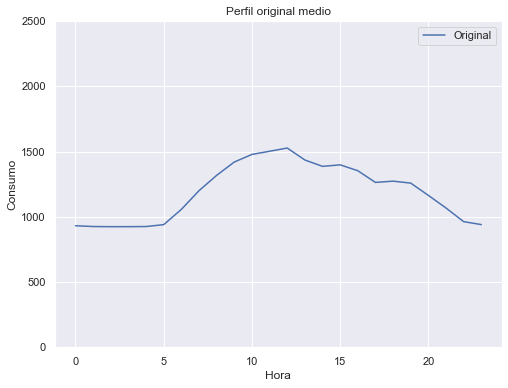

In [9]:
dd=tabla(df,'kW_Tot')
ddm=np.array(dd.mean()['kW_Tot'])
plt.plot(np.transpose(ddm),label="Original")
plt.xlabel('Hora')
plt.ylabel('Consumo')
plt.ylim(bottom=0,top=2500)
plt.title('Perfil original medio')
plt.legend()
plt.savefig(dirfigs+"perfilOriginal.eps", format='eps')
plt.show()

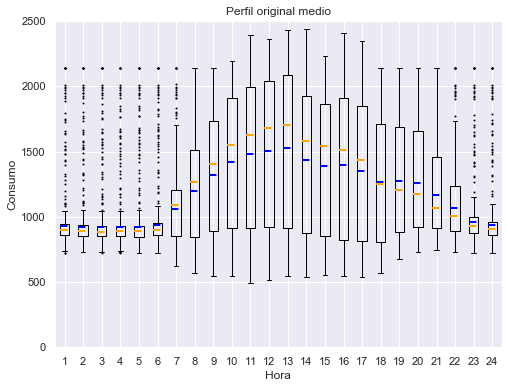

In [10]:
flierprops = dict(marker='o', markerfacecolor='black', markersize=2,markeredgecolor='none')
medianprops = dict(linestyle='--', linewidth=2, color='orange')
meanprops = dict(linestyle='--', linewidth=2, color='blue')
plt.boxplot(np.transpose(dd['kW_Tot']),flierprops=flierprops,showmeans=True,
            meanprops =meanprops,meanline=True,medianprops=medianprops)
plt.xlabel('Hora')
plt.ylabel('Consumo')
plt.ylim(bottom=0,top=2500)
plt.title('Perfil original medio')
plt.savefig(dirfigs+'boxplotOriginal.eps',format='eps')
plt.show()

# Normalizaciones

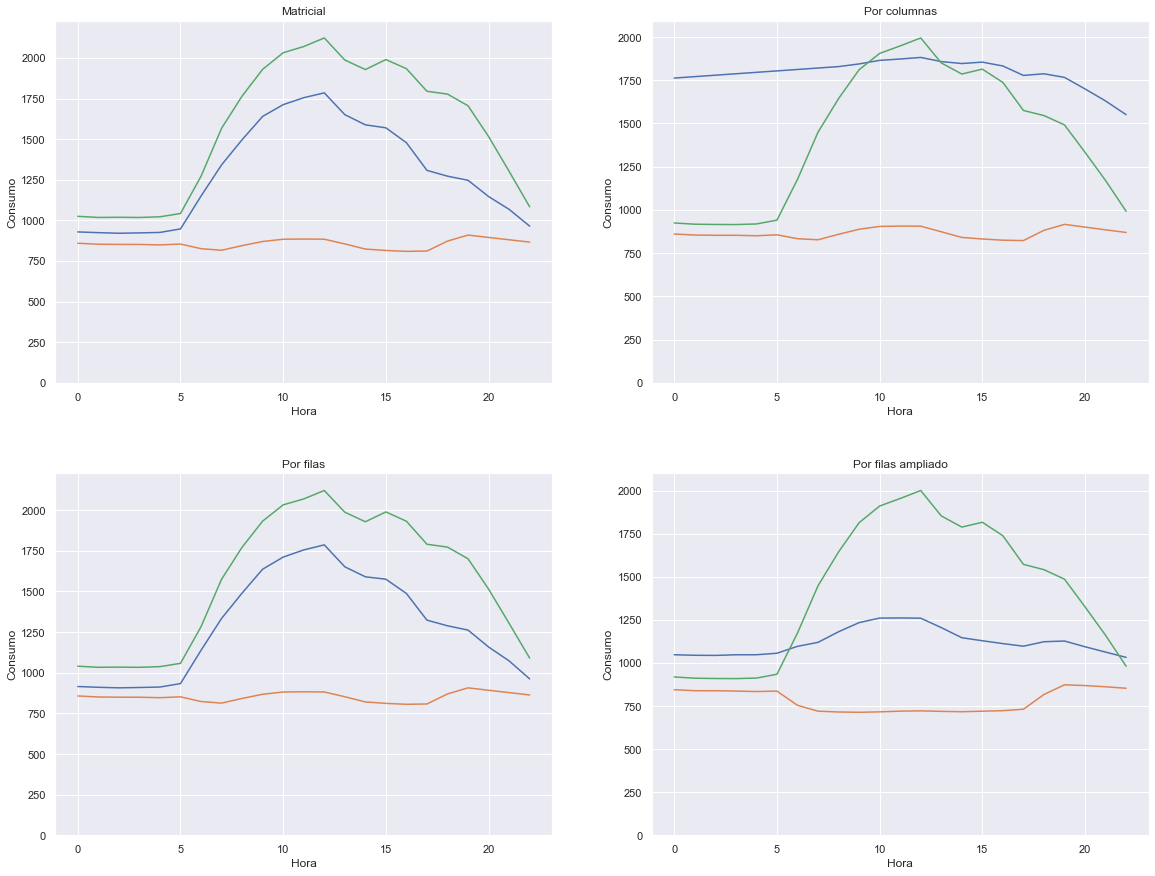

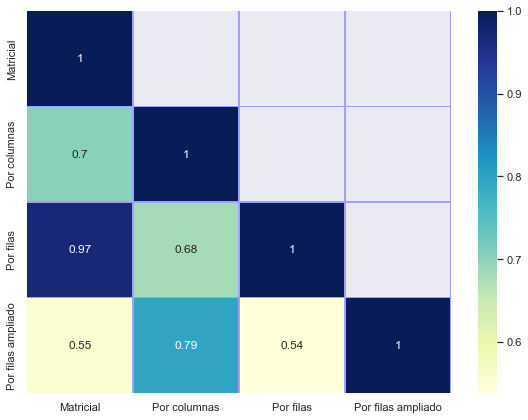

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


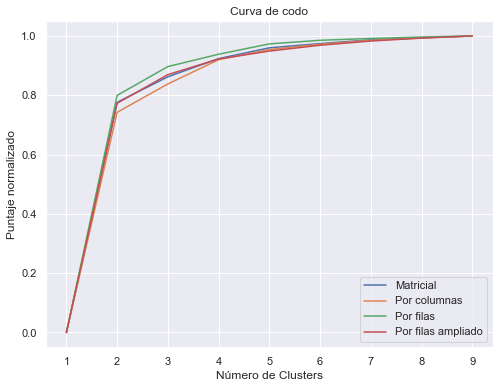

In [11]:
ddNA=normalizarA(dd['kW_Tot'])
ddNB=normalizarB(dd['kW_Tot'])
ddNC=normalizarC(dd['kW_Tot'])
ddND=normalizarD(dd['kW_Tot'])
#ddF=geometria(dd['kW_Tot'])
#ddFNB=normalizarB(ddF)

fr=franjas()
fr.append('MEDIANOR')
ddNDx=ddND[fr]

#nombres=["Original","Matricial","Por columnas","Por filas","Por filas ampliado","Geométrico"]
#valores=[dd.values,ddNA.values,ddNB.values,ddNC.values,ddNDx.values,ddFNB.values]
nombresNormal=["Matricial","Por columnas","Por filas","Por filas ampliado"]
valoresNormal=[ddNA.values,ddNB.values,ddNC.values,ddNDx.values]

kmeans = KMeans(n_clusters=3)
kmeans.fit(dd.values)
Lref=kmeans.labels_
LabelsNormal=crearLabels(valoresNormal,kmeans,Lref)

plotClustersComparados(dd,LabelsNormal,nombresNormal,valoresNormal,dirfigs+"perfilesNormalizadosTotal.eps")
plotHeatmap(dd,LabelsNormal,nombresNormal,dirfigs+"mapaCalorNormalizados.eps")
elbowComparado(10,valoresNormal,nombresNormal,dirfigs+"codosNormalizaciones.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


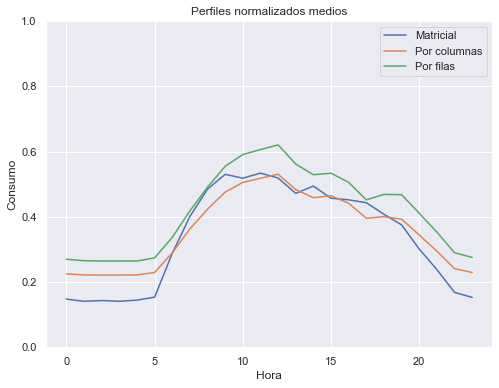

In [12]:
fr=franjas()
ddNAm=np.array(ddNA[fr].mean())
ddNBm=np.array(ddNB[fr].mean())
ddNCm=np.array(ddNC[fr].mean())
plt.plot(np.transpose(ddNBm),label="Matricial")
plt.plot(np.transpose(ddNAm),label="Por columnas")
plt.plot(np.transpose(ddNCm),label="Por filas")
plt.xlabel('Hora')
plt.ylabel('Consumo')
plt.ylim(bottom=0,top=1)
plt.title('Perfiles normalizados medios')
plt.legend()
plt.savefig(dirfigs+"perfilesNormalizados.eps", format='eps')
plt.show()


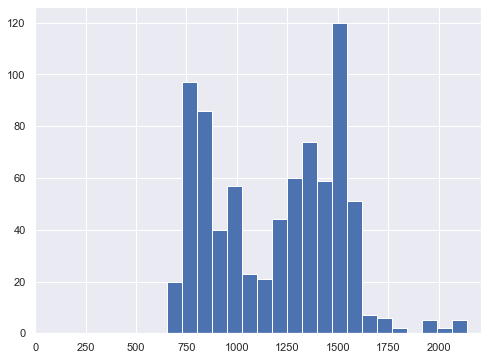

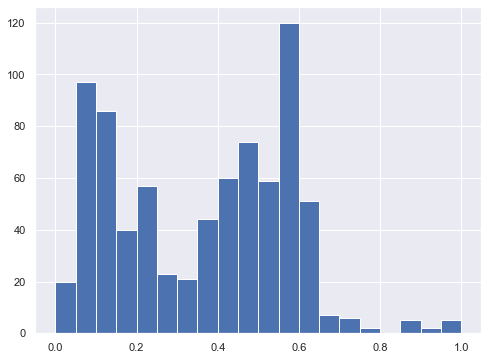

In [13]:
plt.hist(ddND['MEDIA'],bins=20)
plt.xlim(left=0)
plt.savefig(dirfigs+"histoMedia.eps",format='eps')
plt.show()

plt.hist(ddND['MEDIANOR'],bins=20)
plt.savefig(dirfigs+"histoMediaNormalizada.eps",format='eps')
plt.show()

# Parámetros geométricos

In [14]:
ddG=geometria(dd['kW_Tot'])
ddGNB=normalizarB(ddG)
ddGNB.describe()

,MEDIA,PICO,DEV,KURTOSIS
count,779.000000,779.000000,779.000000,779.000000
mean,0.362133,0.489105,0.432334,0.256390
std,0.213309,0.313146,0.296818,0.098785
min,0.000000,0.000000,0.000000,0.000000
25%,0.141862,0.123384,0.132881,0.205274
50%,0.401805,0.572965,0.465198,0.221704
75%,0.552001,0.791586,0.737493,0.269876
max,1.000000,1.000000,1.000000,1.000000


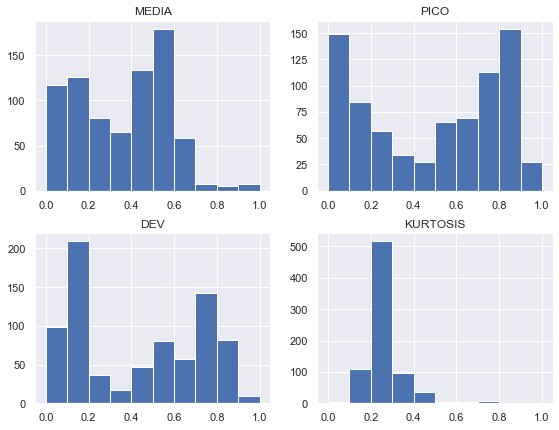

In [15]:
fig, axs = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout()
plt.subplots_adjust(hspace=0.25,wspace=0.2)
nombres=ddGNB.columns
for i in range(0,len(nombres)):
    q,r=divmod(i,2)
    ax=axs[q,r]
    ax.set_title(nombres[i])
    ax.hist(ddGNB[nombres[i]])
plt.savefig(dirfigs+"histoGeometria.eps",format="eps")
plt.show()

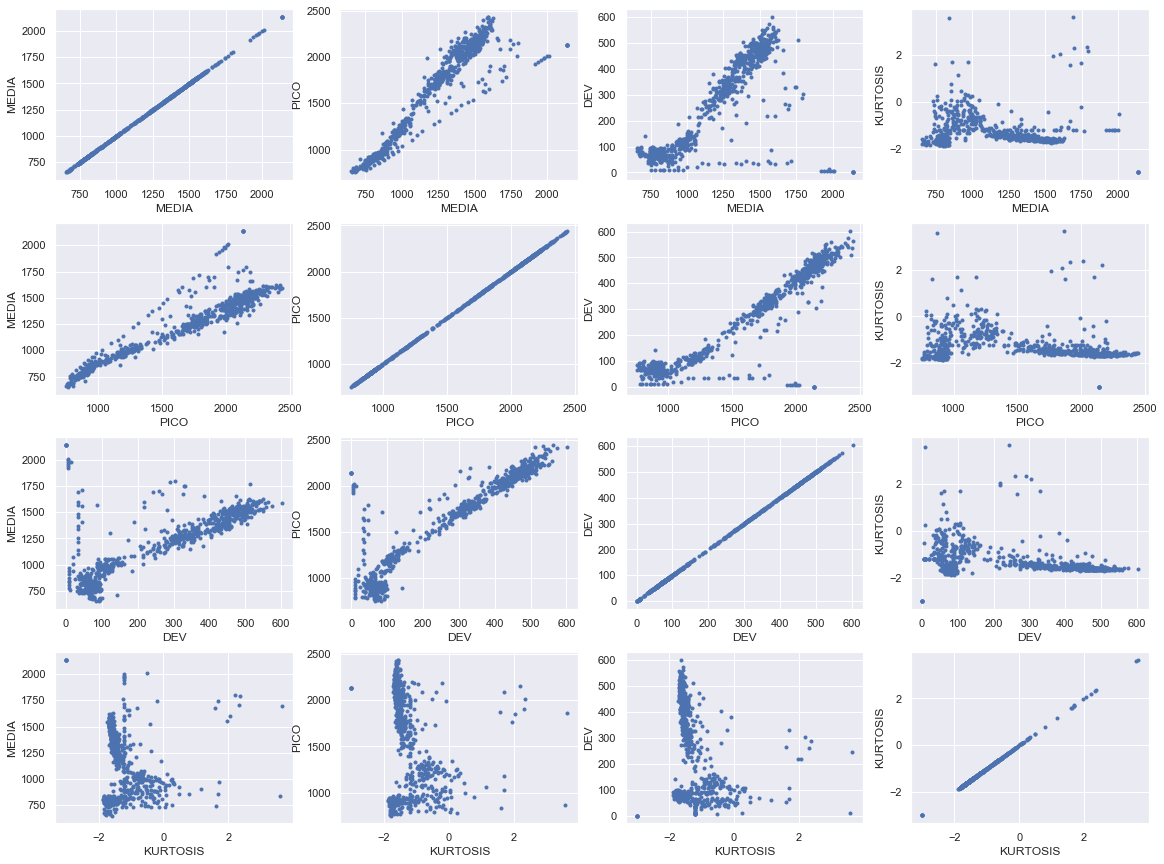

In [16]:
plotCorrelaciones(ddG,ddG.columns,dirfigs+"correlacionesGeometria.eps")

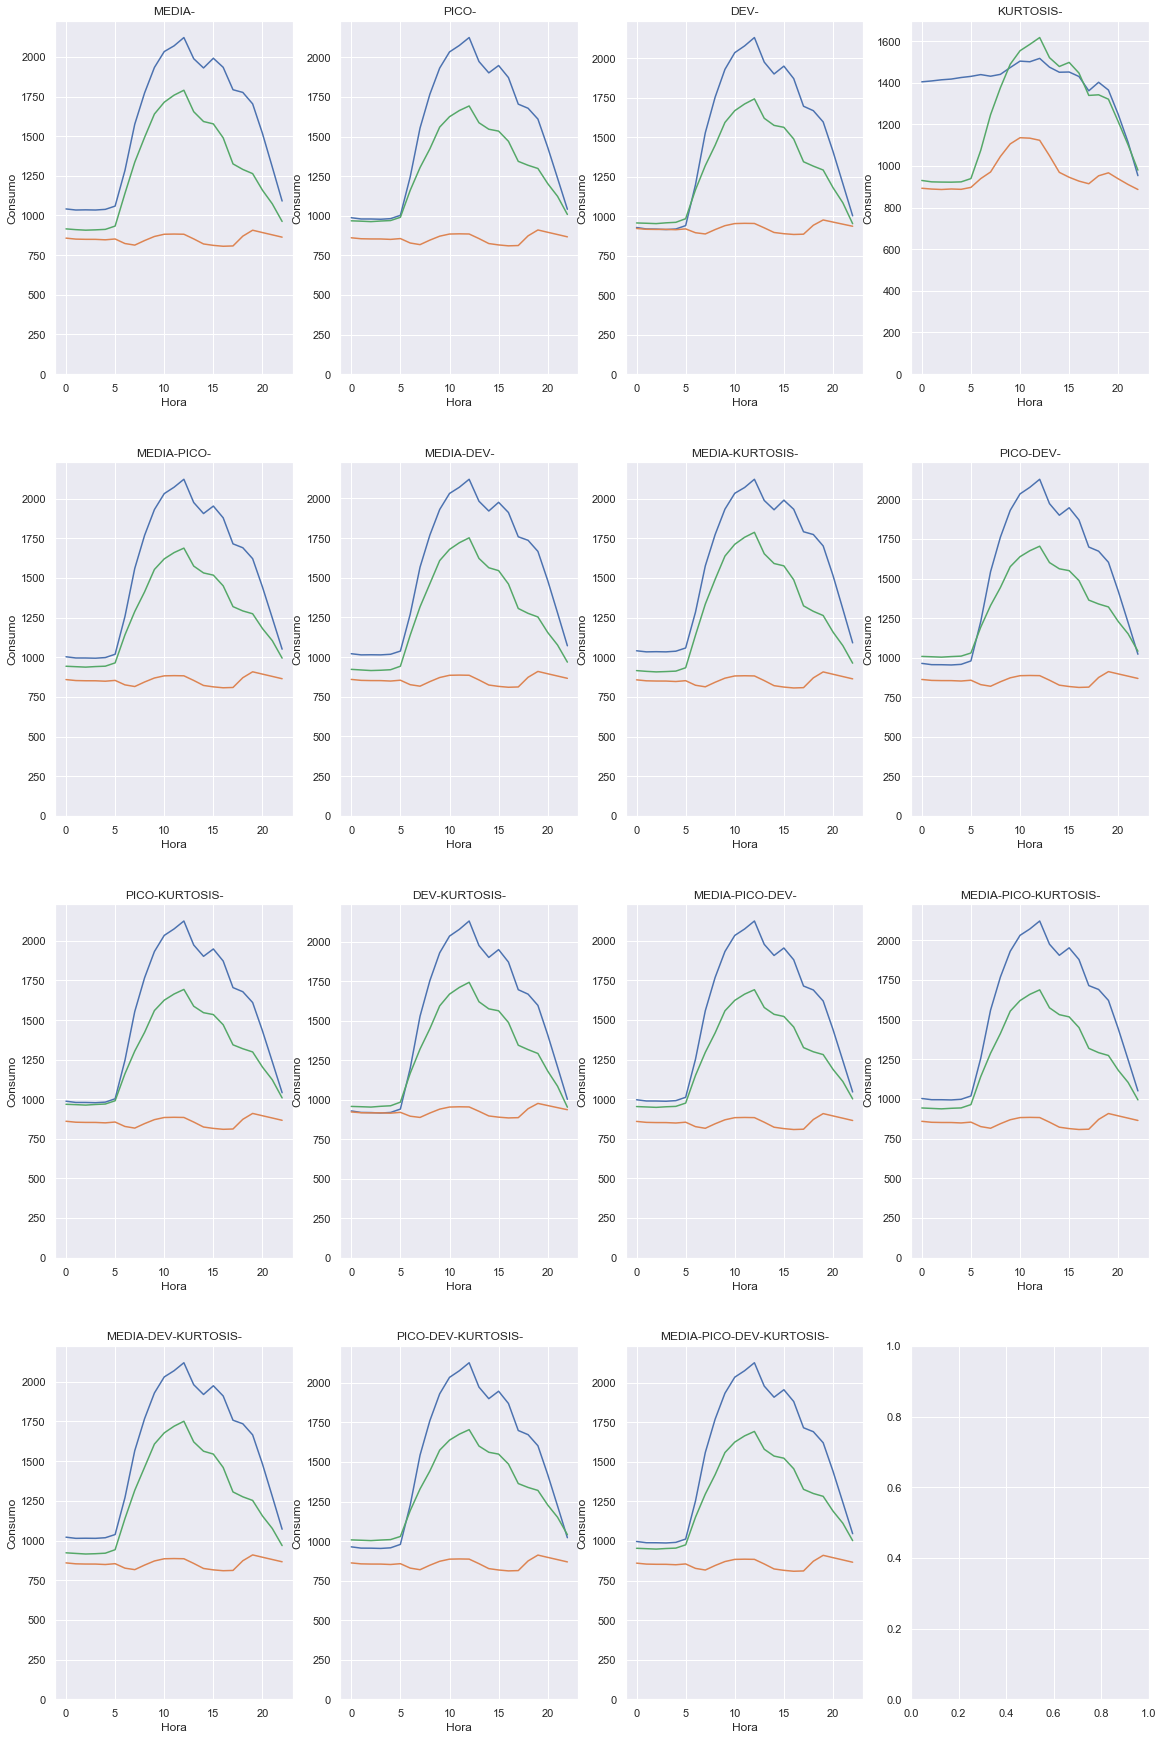

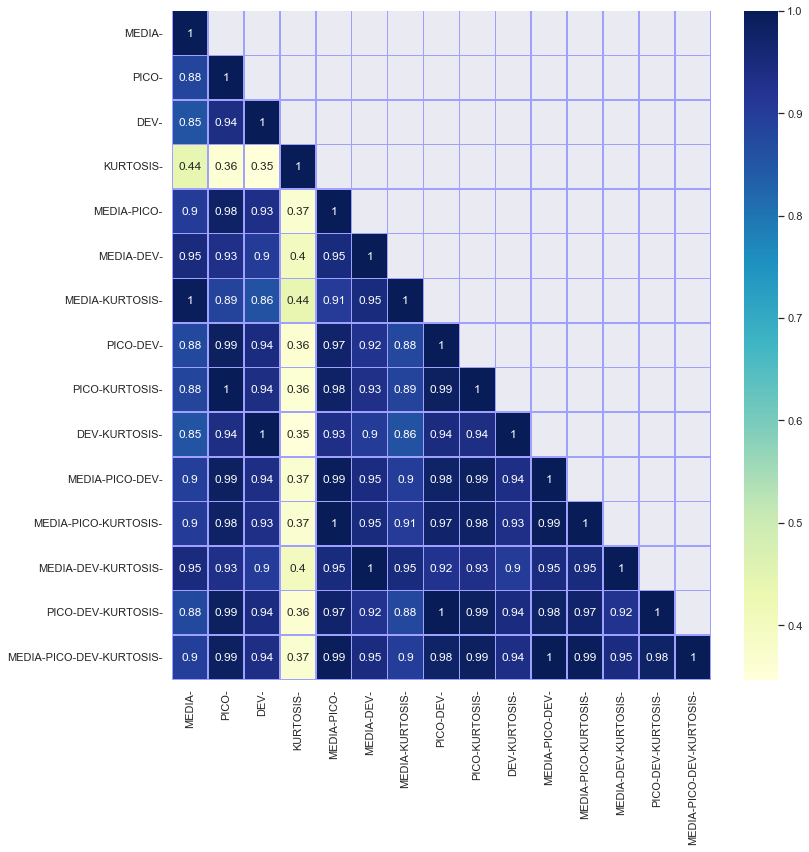

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


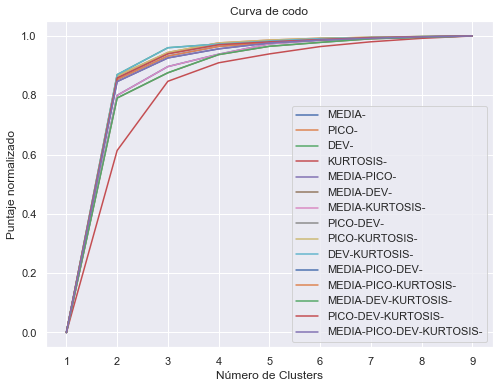

In [17]:
c=[0,1,2,3]
nombresGeo=[]
valoresGeo=[]
features=[]
for k in range(1,5):
    perm = combinations(c,k)
    for i in perm:
        fea=[]
        for j in range(0,len(i)):
            fea.append(i[j])
        features.append(fea)
for i in range(0,len(features)):
    fea=features[i]
    nombre=""
    val=[]
    for j in fea:
        nombre=nombre+ddG.columns[j]+"-"
        val.append(ddG[ddG.columns[j]].values)
    nombresGeo.append(nombre)
    valoresGeo.append(np.transpose(val))

kmeans = KMeans(n_clusters=3)
kmeans.fit(valoresGeo[0])
Lref=kmeans.labels_
LabelsGeo=crearLabels(valoresGeo,kmeans,Lref)
plotClustersComparados(dd,LabelsGeo,nombresGeo,valoresGeo,dirfigs+"perfilesGeoTotal.eps",4)
sns.set(rc = {'figure.figsize':(12,12)})
plotHeatmap(dd,LabelsGeo,nombresGeo,dirfigs+"mapaCalorGeo.eps")
sns.set(rc = {'figure.figsize':(8,6)})
elbowComparado(10,valoresGeo,nombresGeo,dirfigs+"codosGeo.eps")

# Componentes principales - PCA

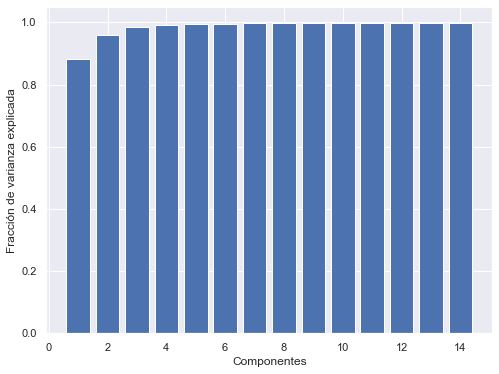

In [18]:
x=[]
y=[]
for i in range(1,15):
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(dd.values)
    x.append(np.sum(pca.explained_variance_ratio_))
    y.append(i)
plt.bar(y,x)
plt.xlabel('Componentes')
plt.ylabel('Fracción de varianza explicada')
plt.savefig(dirfigs+'varianzaComponentesPCA.eps',format='eps')
plt.show()

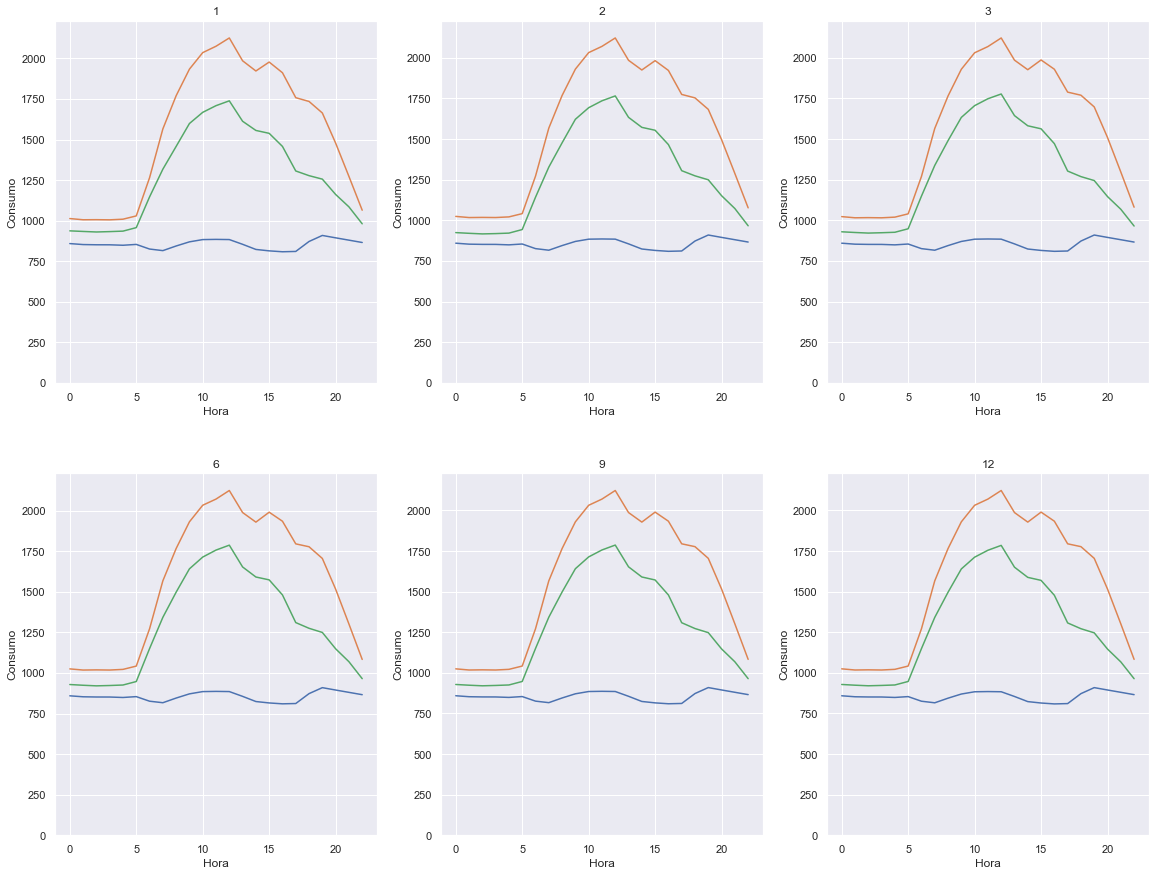

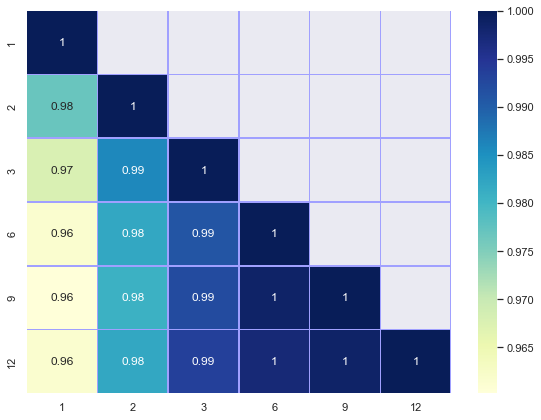

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


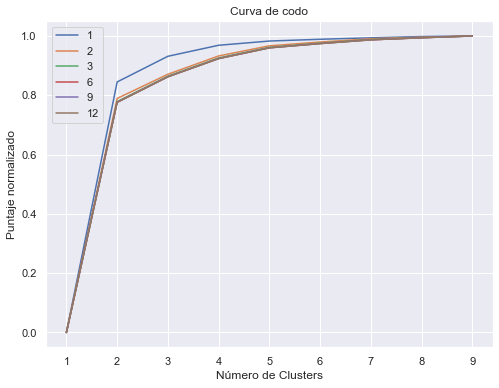

In [19]:
LabelsPCA=[]
valoresPCA=[]
nombresPCA=[]
n_components=[1,2,3,6,9,12]
Lref=dd.values
for i in range(0,len(n_components)):
    pca = PCA(n_components=n_components[i])
    principalComponents = pca.fit_transform(dd.values)
    kmeans.fit(principalComponents)
    valoresPCA.append(principalComponents)
    nombresPCA.append(str(n_components[i]))

kmeans = KMeans(n_clusters=3)
kmeans.fit(valoresPCA[0])
Lref=kmeans.labels_
LabelsPCA=crearLabels(valoresPCA,kmeans,Lref)

plotClustersComparados(dd,LabelsPCA,nombresPCA,valoresPCA,dirfigs+"perfilesPCATotal.eps",3)
plotHeatmap(dd,LabelsPCA,nombresPCA,dirfigs+"mapaCalorPCA.eps")
elbowComparado(10,valoresPCA,nombresPCA,dirfigs+"codosPCA.eps")

# Ampliación de información

In [20]:
df=aumentarConFasores(df)
df.head()

,FECHA,HORA,I_A,I_B,I_C,KVA_Tot,kVAr_Tot,kW_Tot,V_A_B,V_B_C,...,Z_B_C_IMAG,Z_B_C_MAG,Z_B_C_ANG,Z_C_A_REAL,Z_C_A_IMAG,Z_C_A_MAG,Z_C_A_ANG,IL_DESBALANCE,VL_DESBALANCE,Z_ANG_MEDIO
0,2016-10-05,11,109.287041,110.147362,110.887047,2103.854248,277.951416,2085.457520,11013.016602,11043.222656,...,23.077445,172.435558,7.691102,172.571291,21.806983,173.943654,7.202013,0.007448,0.002151,7.592480
1,2016-10-05,12,111.300003,111.064903,113.138161,2197.022217,328.640533,2172.846680,11079.030273,11115.412109,...,27.040751,171.325133,9.081135,169.356734,24.305358,171.091946,8.167079,0.011658,0.002419,8.600828
2,2016-10-05,13,105.136642,105.236641,107.071754,2051.411865,302.450409,2028.595215,11192.564453,11220.931641,...,28.315666,182.496374,8.925926,181.140136,25.330814,182.902704,7.960674,0.011877,0.002118,8.480547
3,2016-10-05,14,99.702164,100.220459,100.730118,1954.322754,312.440918,1929.322754,11219.440430,11249.860352,...,31.100370,193.437129,9.252038,192.214372,30.269427,194.583152,8.949297,0.005143,0.002062,9.199296
4,2016-10-05,15,106.306900,103.913803,105.711502,2033.672485,305.138031,2011.672485,11178.465820,11216.954102,...,29.345507,186.246836,9.065440,179.946389,28.251379,182.150606,8.922539,0.013265,0.002410,8.623362


In [21]:
casosAmpliadoA=['kW_Tot','KVA_Tot','kVAr_Tot','PF_TOT']
casosAmpliadoB=['kW_Tot','kVAr_Tot','Z_ANG_MEDIO','IL_DESBALANCE','VL_DESBALANCE']
ddAmpliadoA=df[casosAmpliadoA]
ddAmpliadoB=df[casosAmpliadoB]

nombresAmpliadoA=['P','S','Q','PF']
nombresAmpliadoB=['P','Q','ANG','ILD','VLD']

valoresAmpliadoA=[]
#for caso in casosAmpliadoA:
#    valoresAmpliadoA.append(normalizarB(tabla(df,caso)).values)
    
valoresAmpliadoA.append(normalizarC(tabla(df,'kW_Tot')).values)
valoresAmpliadoA.append(normalizarC(tabla(df,'KVA_Tot')).values)
valoresAmpliadoA.append(normalizarC(tabla(df,'kVAr_Tot')).values)
valoresAmpliadoA.append(normalizarB(tabla(df,'PF_TOT')).values)
    
valoresAmpliadoB=[]
#for caso in casosAmpliadoB:
#    valoresAmpliadoB.append(normalizarB(tabla(df,caso)).values)
    
valoresAmpliadoB.append(normalizarC(tabla(df,'kW_Tot')).values)
valoresAmpliadoB.append(normalizarC(tabla(df,'kVAr_Tot')).values)
valoresAmpliadoB.append(normalizarB(tabla(df,'Z_ANG_MEDIO')).values)
valoresAmpliadoB.append(normalizarB(tabla(df,'IL_DESBALANCE')).values)
valoresAmpliadoB.append(normalizarB(tabla(df,'VL_DESBALANCE')).values)


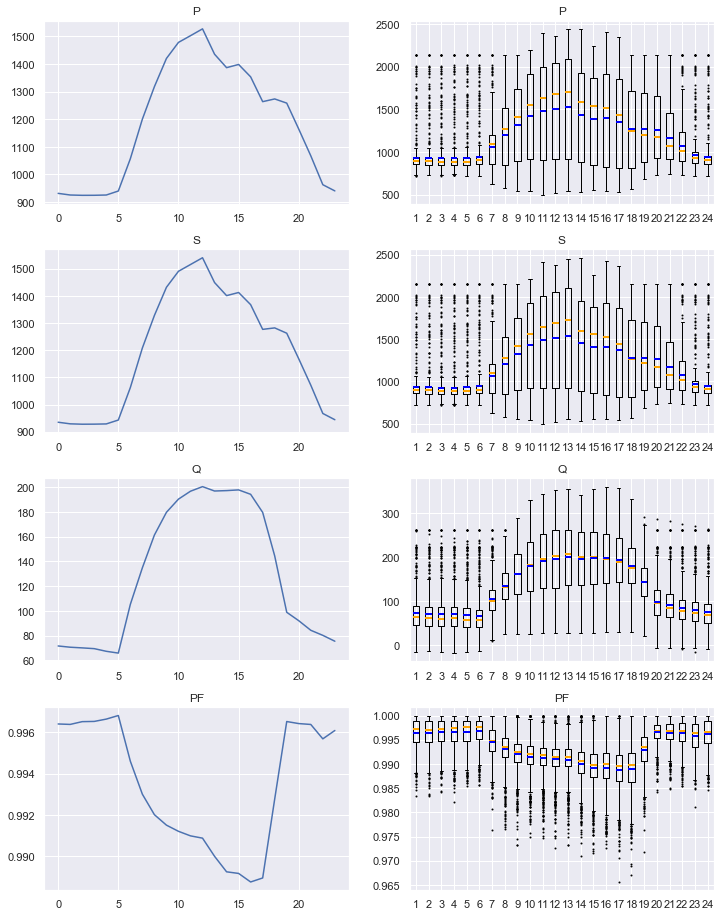

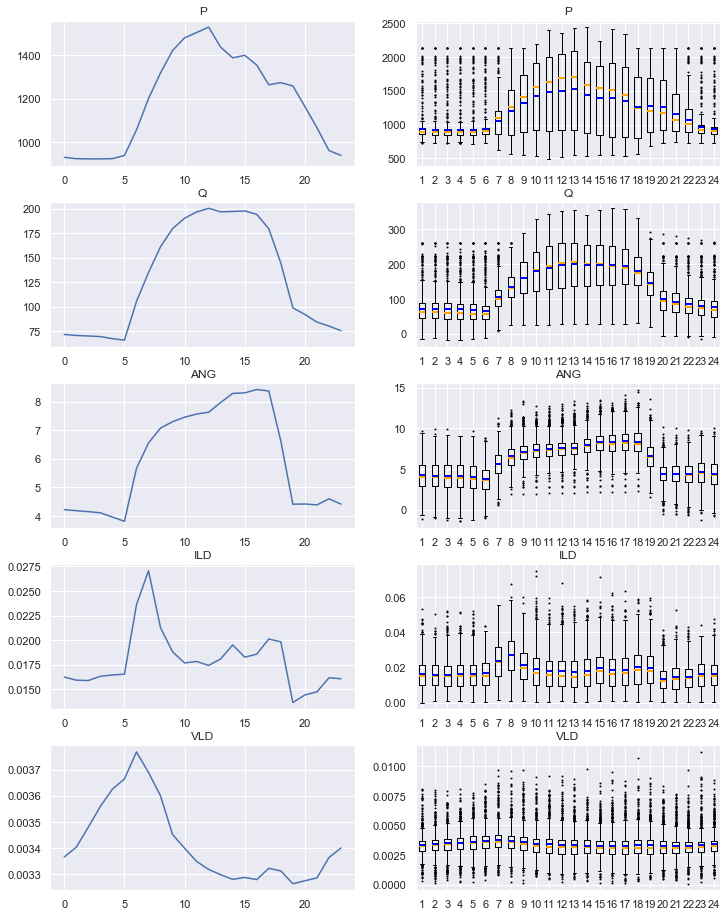

In [22]:
nx=len(casosAmpliadoA)
fig, axs = plt.subplots(nx,2,figsize=(12,16))
plt.subplots_adjust(hspace=0.25,wspace=0.2)

flierprops = dict(marker='o', markerfacecolor='black', markersize=2,markeredgecolor='none')
medianprops = dict(linestyle='--', linewidth=2, color='orange')
meanprops = dict(linestyle='--', linewidth=2, color='blue')

for i in range(0,nx):
    datos=tabla(df,casosAmpliadoA[i])
    ddm=np.array(datos.mean())
    ax=axs[i,0]
    ax.plot(ddm)
    ax.set_title(nombresAmpliadoA[i])

    ax=axs[i,1]
    ax.boxplot(np.transpose(datos),flierprops=flierprops,showmeans=True,
                meanprops =meanprops,meanline=True,medianprops=medianprops)
    ax.set_title(nombresAmpliadoA[i])
plt.savefig(dirfigs+'mediasBoxAmpliadoA.eps',format='eps')
plt.show()

nx=len(casosAmpliadoB)
fig, axs = plt.subplots(nx,2,figsize=(12,16))
plt.subplots_adjust(hspace=0.25,wspace=0.2)
for i in range(0,nx):
    datos=tabla(df,casosAmpliadoB[i])
    ddm=np.array(datos.mean())
    ax=axs[i,0]
    ax.plot(ddm)
    ax.set_title(nombresAmpliadoB[i])

    ax=axs[i,1]
    ax.boxplot(np.transpose(datos),flierprops=flierprops,showmeans=True,
                meanprops =meanprops,meanline=True,medianprops=medianprops)
    ax.set_title(nombresAmpliadoB[i])
plt.savefig(dirfigs+'mediasBoxAmpliadoB.eps',format='eps')
plt.show()


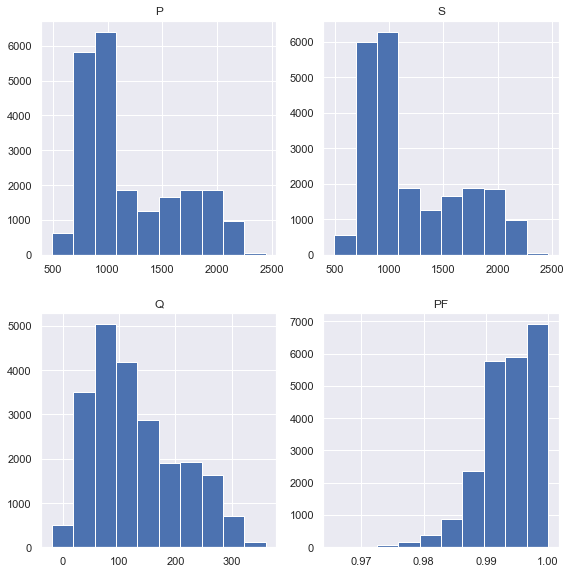

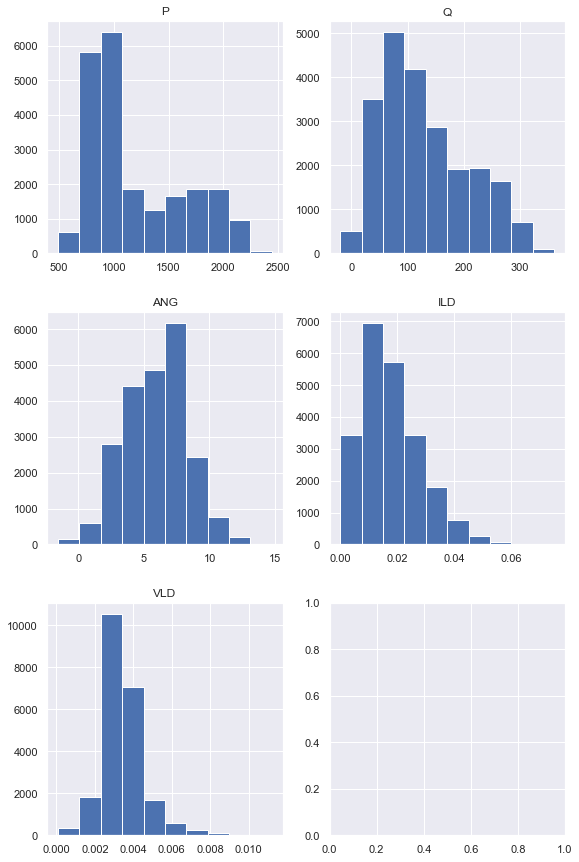

In [23]:
fig, axs = plt.subplots(2,2,figsize=(8,8))
fig.tight_layout()
plt.subplots_adjust(hspace=0.25,wspace=0.2)
nombres=ddAmpliadoA.columns
for i in range(0,len(nombres)):
    q,r=divmod(i,2)
    ax=axs[q,r]
    ax.set_title(nombresAmpliadoA[i])
    ax.hist(ddAmpliadoA[casosAmpliadoA[i]])
plt.savefig(dirfigs+"histoAmpliadoA.eps",format="eps")
plt.show()

fig, axs = plt.subplots(3,2,figsize=(8,12))
fig.tight_layout()
plt.subplots_adjust(hspace=0.25,wspace=0.2)
nombres=ddAmpliadoB.columns
for i in range(0,len(nombres)):
    q,r=divmod(i,2)
    ax=axs[q,r]
    ax.set_title(nombresAmpliadoB[i])
    ax.hist(ddAmpliadoB[casosAmpliadoB[i]])
plt.savefig(dirfigs+"histoAmpliadoB.eps",format="eps")
plt.show()



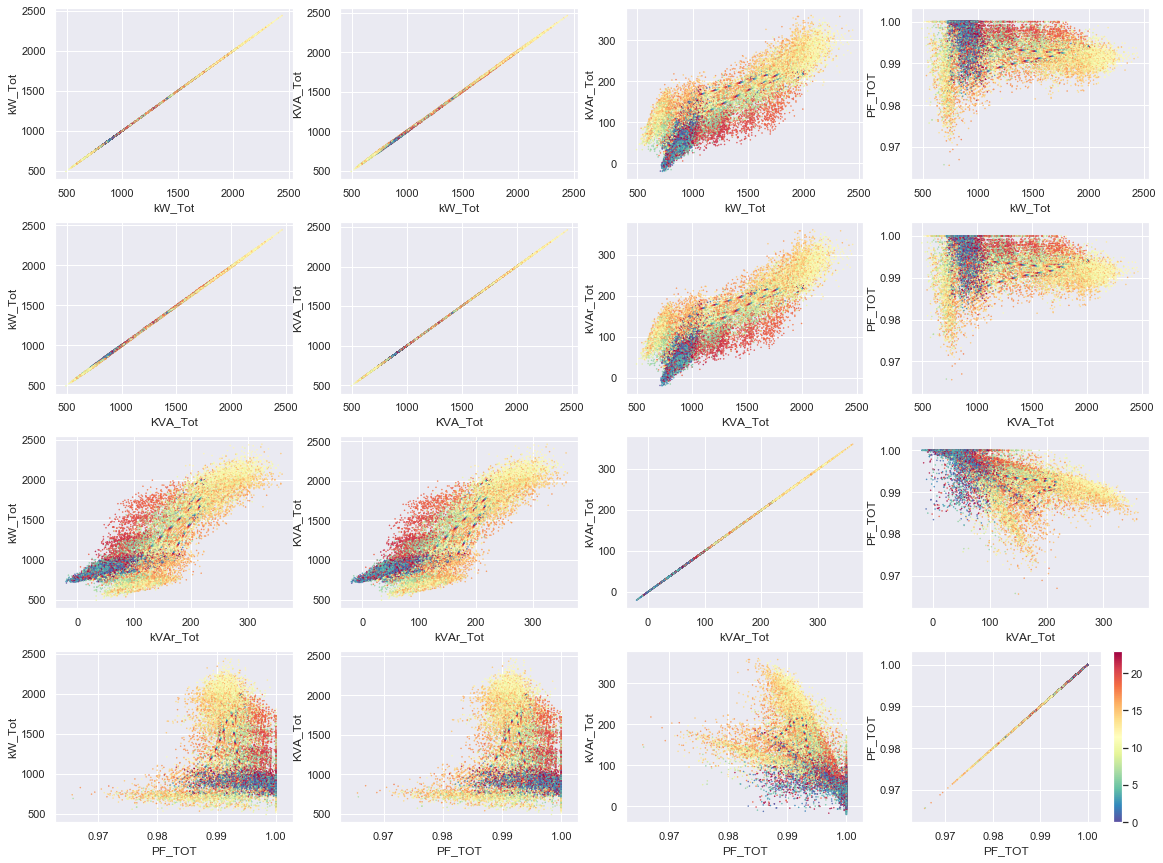

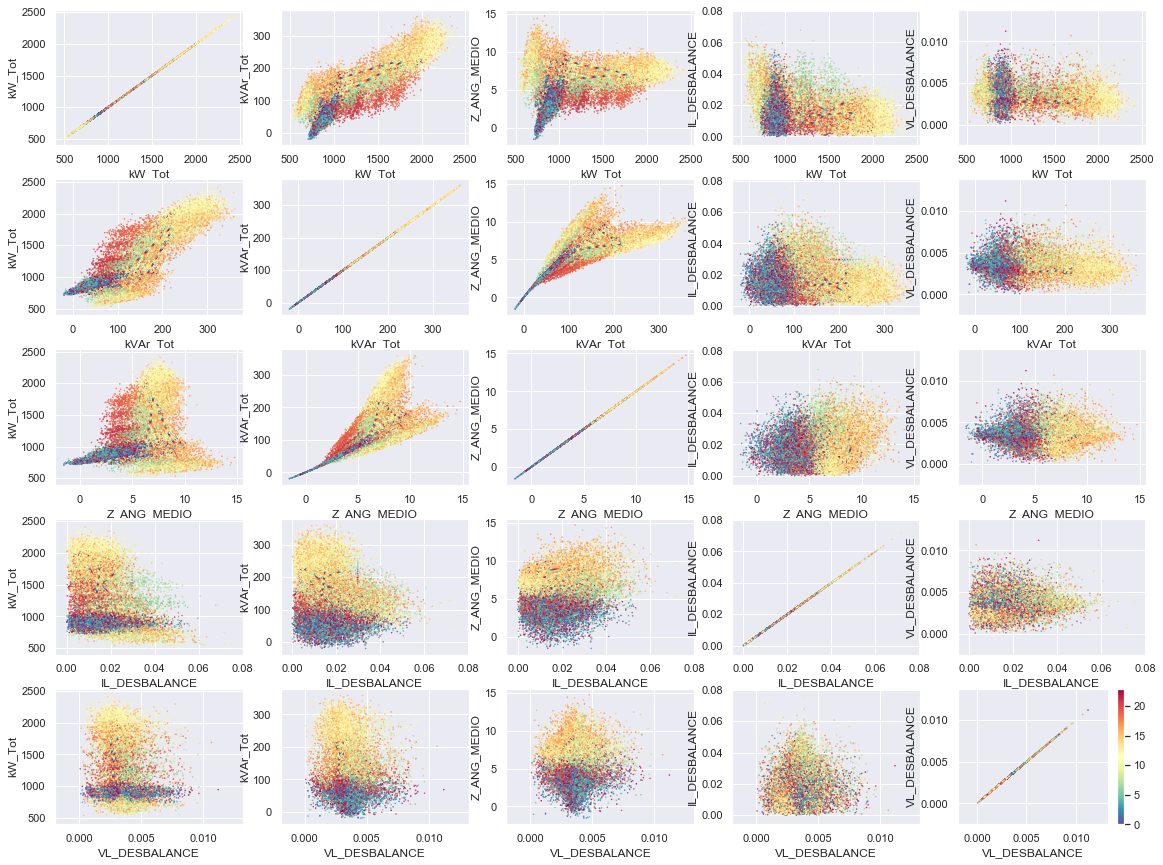

In [24]:
plotCorrelacionesB(ddAmpliadoA,casosAmpliadoA,dirfigs+"correlacionesAmpliadoA.png",df['HORA'].astype(int),'Spectral_r')
plotCorrelacionesB(ddAmpliadoB,casosAmpliadoB,dirfigs+"correlacionesAmpliadoB.png",df['HORA'].astype(int),'Spectral_r')


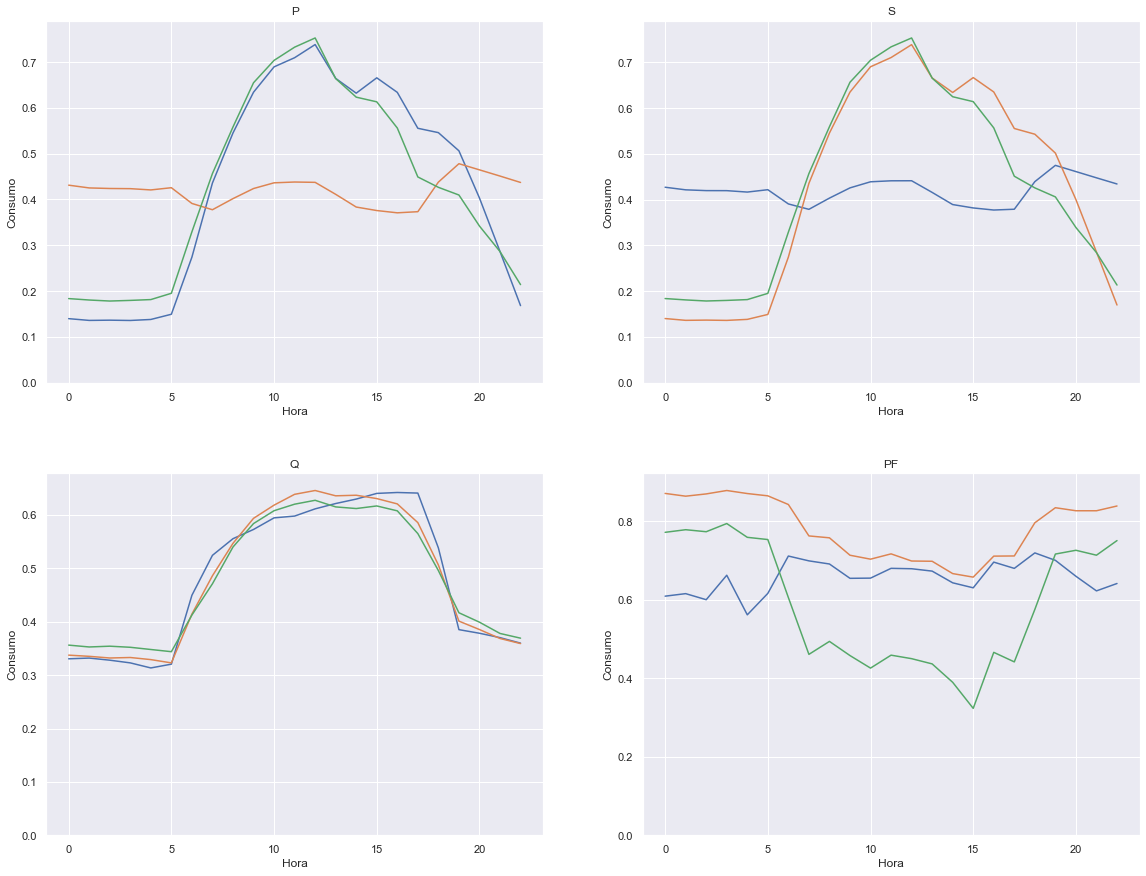

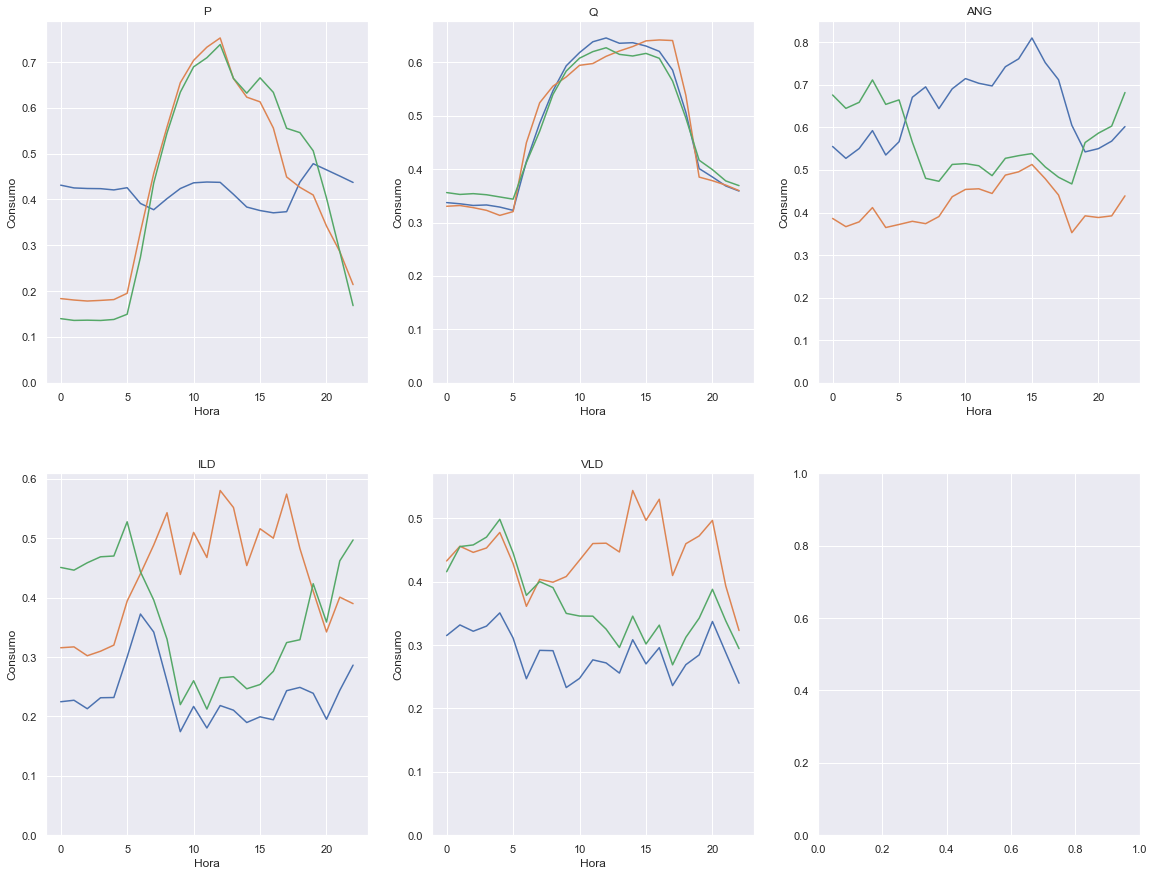

In [25]:
kmeans = KMeans(n_clusters=3)
LabelsAmpliadoA=[]
nx=2
fig, axs = plt.subplots(math.ceil(len(valoresAmpliadoA)/nx), nx,figsize=(16,6*math.ceil(len(valoresAmpliadoA)/nx)))
fig.tight_layout()
plt.subplots_adjust(hspace=0.25,wspace=0.2)
for i in range(0,len(valoresAmpliadoA)):
    kmeans.fit(valoresAmpliadoA[i])
    CL=kmeans.cluster_centers_
    LabelsAmpliadoA.append(kmeans.labels_)
    q,r=divmod(i,nx)
    ax=axs[q,r]
    plotClusters(np.array(CL),nombresAmpliadoA[i],ax)
plt.savefig(dirfigs+"perfilesAmpliadoATotal.eps", format='eps')
plt.show()

kmeans = KMeans(n_clusters=3)
LabelsAmpliadoB=[]
nx=3
fig, axs = plt.subplots(math.ceil(len(valoresAmpliadoB)/nx), nx,figsize=(16,6*math.ceil(len(valoresAmpliadoB)/nx)))
fig.tight_layout()
plt.subplots_adjust(hspace=0.25,wspace=0.2)
for i in range(0,len(valoresAmpliadoB)):
    kmeans.fit(valoresAmpliadoB[i])
    CL=kmeans.cluster_centers_
    LabelsAmpliadoB.append(kmeans.labels_)
    q,r=divmod(i,nx)
    ax=axs[q,r]
    plotClusters(np.array(CL),nombresAmpliadoB[i],ax)
plt.savefig(dirfigs+"perfilesAmpliadoBTotal.eps", format='eps')
plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


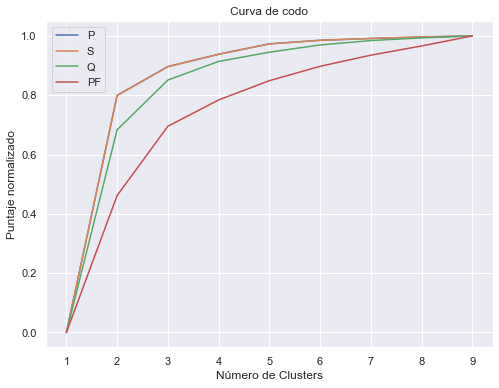

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


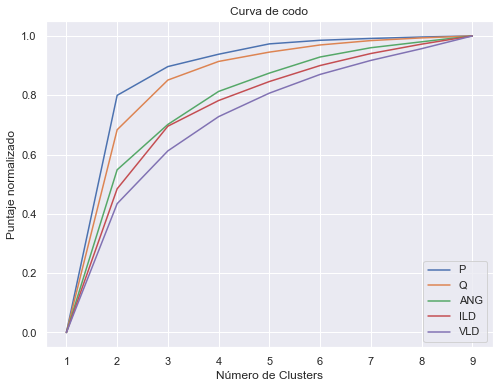

In [26]:
#plotHeatmap(dd,LabelsAmpliado,nombresAmpliado,dirfigs+"mapaCalorAmpliado.eps")

elbowComparado(10,valoresAmpliadoA,nombresAmpliadoA,dirfigs+"codosAmpliadoA.eps")
elbowComparado(10,valoresAmpliadoB,nombresAmpliadoB,dirfigs+"codosAmpliadoB.eps")

In [27]:
#plotHeatmap(dd,LabelsAmpliado,nombresAmpliado,dirfigs+"mapaCalorAmpliado.eps")

def matrizLabels(LA,LB):
    MM=np.zeros((max(LA)+1,max(LB)+1))
    numceros=0
    for i in range(0,len(LA)):
        MM[LA[i]][LB[i]]=MM[LA[i]][LB[i]]+1
        if MM[LA[i]][LB[i]]==0:
            numceros=numceros+1
#    total=sum(sum(MM))
#    MM=(1/total)*MM
    ceros=numceros/(len(LA)*len(LA))
    return ceros,MM

def latexMatrizMatricesLabels(L,nombres):
    tex=""
    tex=tex + "\\begin{tabular}{p{0.5cm}"
    for i in range(0,len(L)):
        tex=tex+"c"
    tex=tex+"}\n"
    for i in range(0,len(L)):
        tex=tex + " & " + nombres[i]
    tex=tex+"\\\\ \n"
    for i in range(0,len(L)):
        tex=tex + nombres[i]
        for j in range(0,len(L)):
            ceros, MM=matrizLabels(L[i],L[j])
            texA=a2l.to_ltx(MM, frmt = '{:6.0f}', arraytype = 'pmatrix', mathform = True, print_out=False)
            tex=tex+" & \n $"+texA+"$" + "\n"
        tex=tex + "\\\\ \n"
    tex=tex + "\end{tabular}\n"
    return tex

In [28]:
nombresAmpliadoB=['P','Q','ANG','ILD','VLD']

texto=latexMatrizMatricesLabels(LabelsAmpliadoA,nombresAmpliadoA)
with open(dirtabs+'correlacionesAmpliadoA.tex', 'w') as f:
    f.write(texto)

texto=latexMatrizMatricesLabels(LabelsAmpliadoB,nombresAmpliadoB)
with open(dirtabs+'correlacionesAmpliadoB.tex', 'w') as f:
    f.write(texto)

# Tarifas

In [29]:
def crearTarifas(perfiles,TarifaPlana,factor):
    Tarifas=np.zeros(shape=perfiles.shape)
    CT=np.zeros(shape=(len(perfiles),1))
    for i in range(0,len(perfiles)):
        CT[i]=TarifaPlana*np.sum(perfiles[i])
        md=np.mean(perfiles[i])
        for j in range(0,24):
            if perfiles[i,j]>md:
                Tarifas[i,j]=1
        PP=0
        PV=0
        for j in range(0,24):
            PP=PP + perfiles[i,j]
            PV=PV + ((Tarifas[i,j]-0)*perfiles[i,j]/(1-0))
        fmin=CT[i]/(PP + ((factor-1)*PV))
        fmax=factor*fmin
        for j in range(0,24):
            Tarifas[i,j]=fmin + (Tarifas[i,j]-0)*(fmax-fmin)/(1-0)
    return Tarifas

def aplicarTarifas(dd,Tarifas,Labels):
    S=0
    for i in range(0,len(dd)):
        for j in range(0,len(dd[i])):
            S=S+dd[i,j]*Tarifas[Labels[i],j]
    return S


def aplicarTarifaPlana(dd,Tarifa):
    S=0
    for i in range(0,len(dd)):
        for j in range(0,len(dd[i])):
            S=S+dd[i,j]*Tarifa
    return S

def calcularDeltaIngresos(dd,ddNX,TarifaPlana,factorTarifario):
    IPlanos=aplicarTarifaPlana(dd.values,TarifaPlana);
    kmeansX = KMeans(n_clusters=3)
    kmeansX.fit(ddNX.values)
    TarifasX=crearTarifas(kmeansX.cluster_centers_,TarifaPlana,factorTarifario)
    ITarifa=aplicarTarifas(dd.values,TarifasX,kmeansX.labels_)
    Delta=(ITarifa-IPlanos)/IPlanos
    return Delta
  


In [30]:
TarifaPlana=100
factorTarifario=1.3
print(calcularDeltaIngresos(dd,ddNA,TarifaPlana,factorTarifario))
print(calcularDeltaIngresos(dd,ddNB,TarifaPlana,factorTarifario))
print(calcularDeltaIngresos(dd,ddNC,TarifaPlana,factorTarifario))
print(calcularDeltaIngresos(dd,ddND,TarifaPlana,factorTarifario))


-0.012189129454750697
-0.029944163864710226
125.62218060907358
125.6631477398337


In [31]:
dir()

['CL',
 'In',
 'KMeans',
 'LabelsAmpliadoA',
 'LabelsAmpliadoB',
 'LabelsGeo',
 'LabelsNormal',
 'LabelsPCA',
 'Lref',
 'Out',
 'PCA',
 'Polygon',
 'TarifaPlana',
 '_',
 '_14',
 '_20',
 '_3',
 '_6',
 '_7',
 '_8',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'a2l',
 'aplicarTarifaPlana',
 'aplicarTarifas',
 'apriori',
 'aumentarConFasores',
 'ax',
 'axs',
 'c',
 'calcularDeltaIngresos',
 'casosAmpliadoA',
 'casosAmpliadoB',
 'cmath',
 'colors',
 'combinations',
 'crearClusters',
 'crearLabels',
 'crearTarifas',
 'datetime',
 'datos',
 'dd',
 'ddAmpliadoA',
 'ddAmpliadoB',
 'ddG',
 'ddGNB',
 'ddNA',
 'dd

In [32]:
ddNA.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 779 entries, 2016-10-06 to 2019-12-02
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   00      779 non-null    float64
 1   01      779 non-null    float64
 2   02      779 non-null    float64
 3   03      779 non-null    float64
 4   04      779 non-null    float64
 5   05      779 non-null    float64
 6   06      779 non-null    float64
 7   07      779 non-null    float64
 8   08      779 non-null    float64
 9   09      779 non-null    float64
 10  10      779 non-null    float64
 11  11      779 non-null    float64
 12  12      779 non-null    float64
 13  13      779 non-null    float64
 14  14      779 non-null    float64
 15  15      779 non-null    float64
 16  16      779 non-null    float64
 17  17      779 non-null    float64
 18  18      779 non-null    float64
 19  19      779 non-null    float64
 20  20      779 non-null    float64
 21  21      779 non-null